# **Preliminary Exploration of the PerturbMulti diet dataset**
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lealagonotte/Geometric_data_analysis_project/blob/raph-colab/tests/perturb_multi_colab.ipynb)  
See on Hugging Face: https://huggingface.co/datasets/xingjiepan/PerturbMulti

## **Colab setup**

In [ ]:
!git clone https://github.com/lealagonotte/Geometric_data_analysis_project.git
%cd Geometric_data_analysis_project/
!git clone https://github.com/raphaelrubrice/Perturb-OT.git
!git checkout raph-colab

In [ ]:
!pip install -r requirements-env.txt

YOU WILL NEED TO RESTART THE SESSION AFTER THE PREVIOUS CELL.
After restarting you should have a working env.

Let's check that we have succesfully recreated the env

In [ ]:
import sys

from perturbot.match import (
    get_coupling_cotl, 
    get_coupling_cotl_sinkhorn, 
    get_coupling_egw_labels_ott,
    get_coupling_egw_all_ott,
    get_coupling_eot_ott,
    get_coupling_leot_ott,
    get_coupling_egw_ott,
    get_coupling_cot, 
    get_coupling_cot_sinkhorn, 
    get_coupling_gw_labels,
    get_coupling_fot,
)
from perturbot.predict import train_mlp
import ot
print("Imports succeeded")

## **Imports**

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scanpy as sc
from scanpy.preprocessing import subsample
from tqdm.auto import tqdm
import itertools
import os

/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/phalafail/MVA/Geometric_data_analysis_project'

## **Download the data**

In [ ]:
%cd Geometric_data_analysis_project/
!mkdir data
%cd data
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/RNA_scaled_diet_conditions_20240411.h5ad
!wget https://huggingface.co/datasets/xingjiepan/PerturbMulti/resolve/main/protein_intensities_diet_conditions_20240411.h5ad

In [ ]:
%cd /content/Geometric_data_analysis_project/

## **Load & process data**

In [2]:
path_rna_diet = "./data/RNA_scaled_diet_conditions_20240411.h5ad"
rna_diet = ad.read_h5ad(path_rna_diet)

In [3]:
rna_diet.obs.head()

,fov,x,y,z,area,cond,batch
id,,,,,,,
100001368350601220443305171011375780801,717,6666.830785,7236.949846,0,296.588262,adlib,IE29
100001800432857001134785976606575060287,849,8413.609407,7209.004054,9,28.819318,adlib,IE29
100002804203690621291738422225750332629,659,6218.665741,3959.272899,6,47.580965,adlib,IE29
100003573867315829655028318295181964954,478,4796.646369,2362.160563,0,596.398900,adlib,IE29
100008668971788868972348129958710863790,885,8984.942123,4629.471220,3,31.794475,adlib,IE29


In [4]:
path_prot_diet = "./data/protein_intensities_diet_conditions_20240411.h5ad"
prot_diet = ad.read_h5ad(path_prot_diet)

In [5]:
prot_diet.obs.head()

,cell_id,condition,cell_name,fov,x,y,z,area,cond,batch,n_genes,n_counts,datatype,leiden,new_leiden,new_leiden_relabeled,cell_type,cluster_type,cell_type_color,cluster_type_color
0,0,adlib_T cell,92741088075053779116951994856866301126,631,10487.513193,125.414363,1,288.918642,adlib,2,79,409.0,merfish,16,2,5,T cell,T cell,8,15
1,1,adlib_T cell,133524280519918220907967806861786402321,847,8363.706168,6825.614590,0,342.417939,adlib,1,49,184.0,merfish,16,2,5,T cell,T cell,8,15
2,2,adlib_T cell,116603158813595984705504213443274415416,781,12026.084383,855.943716,4,52.808116,adlib,2,30,113.0,merfish,16,2,5,T cell,T cell,8,15
3,3,adlib_T cell,317866311329856700012086944685408447975,272,3096.611149,2092.912335,5,123.233572,adlib,1,63,292.0,merfish,16,2,5,T cell,T cell,8,15
4,4,adlib_T cell,150257798544309436723007524508073422512,654,6152.449135,7133.888484,0,96.995168,adlib,1,24,53.0,merfish,16,2,5,T cell,T cell,8,15


In [6]:
GENES = list(rna_diet.var.index)
PROTEINS = list(prot_diet.var.index)
CONDITIONS = list(np.unique(rna_diet.obs['cond']))

In [7]:
print(f"Number of Genes: {len(GENES)}")
print(f"Number of Proteins: {len(PROTEINS)}")
print(f"Number of conditions: {len(CONDITIONS)} ({CONDITIONS})")

Number of Genes: 260
Number of Proteins: 18
Number of conditions: 3 (['adlib', 'fasted', 'hfd'])


In [8]:
print("Maximum expression", np.max(rna_diet.X))
print("Minimum expression", np.min(rna_diet.X))

Maximum expression 10.0
Minimum expression -0.7879467953842848


In [9]:
print("Maximum intensity", np.max(prot_diet.X))
print("Minimum intensity", np.min(prot_diet.X))

Maximum intensity nan
Minimum intensity nan


In [10]:
print("There are nans:", np.isnan(prot_diet.X).sum())

There are nans: 36


In [11]:
nan_mask_rowise = np.where(np.isnan(prot_diet.X).sum(axis=1) > 0, True, False) 
print(f"These nans come from {nan_mask_rowise.sum()} rows")
prot_diet.X[nan_mask_rowise,:]

These nans come from 2 rows


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan]])

Let's remove these rows

In [12]:
prot_diet_noNA = prot_diet[~nan_mask_rowise,:]
print("Maximum intensity", np.max(prot_diet_noNA.X))
print("Minimum intensity", np.min(prot_diet_noNA.X))

Maximum intensity 0.8667076230049133
Minimum intensity 0.004974730312824249


In [13]:
prot_diet.obs["cond"].value_counts() / prot_diet.shape[0]

cond
adlib     0.352573
fasted    0.329616
hfd       0.317811
Name: count, dtype: float64

In [14]:
rna_diet.obs["cond"].value_counts() / rna_diet.shape[0]

cond
adlib     0.364393
fasted    0.322702
hfd       0.312905
Name: count, dtype: float64

All three diets are quite well balanced in the dataset.  
For the remaining cells we will use a subset of the data where only a fraction of cells of each conditions are used for speed purposes.

In [ ]:
def condition_subsample(adata, frac, cond_col):
    all_conditions = np.unique(adata.obs[cond_col])
    adata_list = []
    for cond in all_conditions:
        cond_adata = adata[adata.obs[cond_col] == cond]
        adata_list.append(subsample(cond_adata,frac,copy=True))
    return ad.concat(adata_list, axis=0)

FRAC = 0.02

In [16]:
sub_rna_diet = condition_subsample(rna_diet, FRAC, 'cond')
sub_rna_diet

AnnData object with n_obs × n_vars = 738 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'

In [17]:
sub_prot_diet = condition_subsample(prot_diet, FRAC, 'cond')
sub_prot_diet

AnnData object with n_obs × n_vars = 500 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'

We can check that condition proportions are respected

In [18]:
sub_rna_diet.obs['cond'].value_counts() / sub_rna_diet.shape[0]

cond
adlib     0.364499
fasted    0.322493
hfd       0.313008
Name: count, dtype: float64

In [19]:
sub_prot_diet.obs['cond'].value_counts() / sub_prot_diet.shape[0]

cond
adlib     0.352
fasted    0.330
hfd       0.318
Name: count, dtype: float64

## **Visualize data**

Great, now let's visualize our data with UMAP

In [20]:
def pca_data(adata):
    # Computing reduced dimension
    print("Reducing dimension..")
    sc.tl.pca(adata)
    print("Plotting PCA Variance ratios..")
    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=False)

def plot_umap(adata, cond_col, 
              reduce_data=True, 
              n_neighbors=15, 
              metric='euclidean', 
              min_dist=0.1, 
              spread=1.0):
    if reduce_data:
        pca_data(adata)
    # Obtain neighbors
    print("Obtaining neighbors..")
    sc.pp.neighbors(adata, n_neighbors=n_neighbors, metric=metric)
    # Compute umap
    print("Computing UMAP..")
    sc.tl.umap(adata, min_dist=min_dist, spread=spread)
    # Plot
    print("Plotting..")
    sc.pl.umap(adata, color=cond_col)

Reducing dimension..
Plotting PCA Variance ratios..


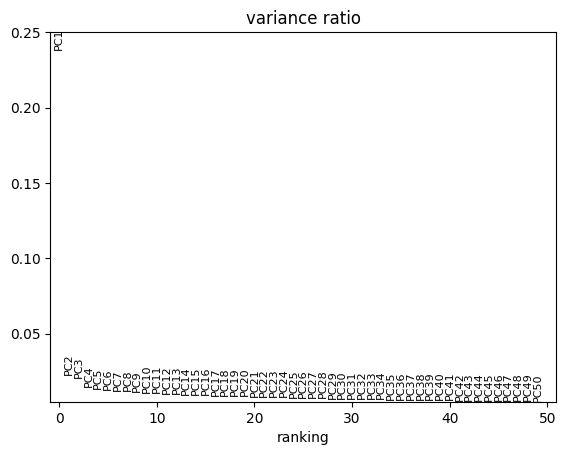

Obtaining neighbors..


/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Computing UMAP..
Plotting..


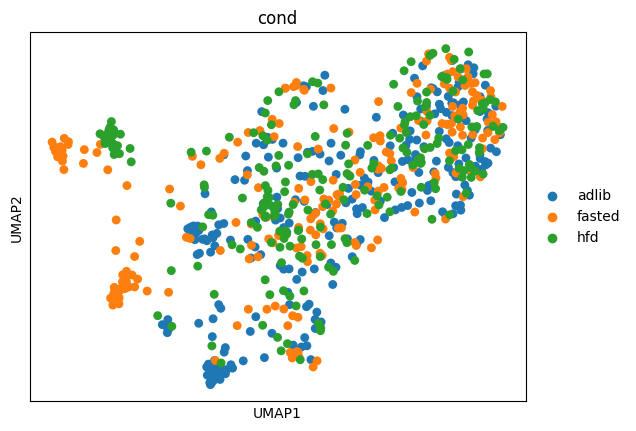

In [21]:
plot_umap(sub_rna_diet, 'cond', 
          reduce_data=True, 
          n_neighbors=15, 
          metric='euclidean', 
          min_dist=0.1, 
          spread=1.0)

In [22]:
sub_rna_diet

AnnData object with n_obs × n_vars = 738 × 260
    obs: 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch'
    uns: 'pca', 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Obtaining neighbors..


Computing UMAP..
Plotting..


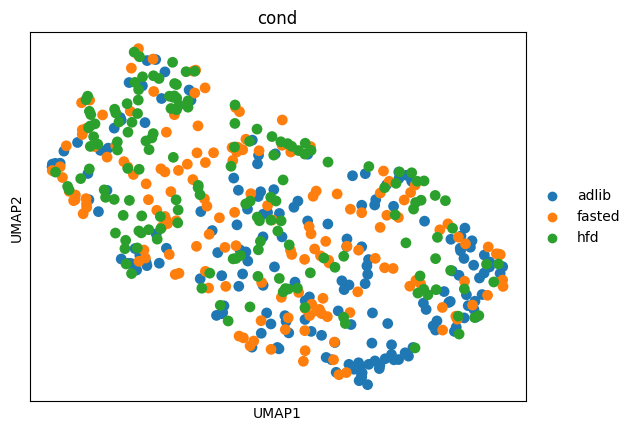

In [23]:
plot_umap(sub_prot_diet, 'cond', 
          reduce_data=False, 
          n_neighbors=15, 
          metric='euclidean', 
          min_dist=0.1, 
          spread=1.0)

In [24]:
sub_prot_diet

AnnData object with n_obs × n_vars = 500 × 18
    obs: 'cell_id', 'condition', 'cell_name', 'fov', 'x', 'y', 'z', 'area', 'cond', 'batch', 'n_genes', 'n_counts', 'datatype', 'leiden', 'new_leiden', 'new_leiden_relabeled', 'cell_type', 'cluster_type', 'cell_type_color', 'cluster_type_color'
    uns: 'neighbors', 'umap', 'cond_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

We clearly do not have a UMAP space as good as the authors, we need to find better UMAP hyperparameters in hope of identifying a good combination to visualize our data.

In [25]:
def grid_search_umap(adata):
    n_neighbors_list = [15, 50, 100]
    min_dist_list = [0.01, 0.1, 0.3, 0.5]
    spread_list = [0.5, 1.0, 1.5, 10]
    metrics = ['euclidean']

    # Create all combinations
    param_grid = list(itertools.product(n_neighbors_list, min_dist_list, spread_list, metrics))

    # Run grid search
    for i, (n_neighbors, min_dist, spread, metric) in tqdm(enumerate(param_grid), total=len(param_grid)):
        print(f"Running UMAP with n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread}, metric={metric}")
    
        try:
            plot_umap(
                sub_rna_diet,
                'cond',
                reduce_data=False,
                n_neighbors=n_neighbors,
                metric=metric,
                min_dist=min_dist,
                spread=spread
            )
        except Exception as e:
            print(f"Failed with: {e}")

I ran it, it took about 30 min on my device but it revealed that none of the proposed combinations really helped. I suspect that the apparent structure at ~5k cells could be much different than that with the whole dataset.

In [26]:
# grid_search_umap(sub_rna_diet)

In [27]:
# grid_search_umap(sub_prot_diet)

## **Fused Gromov-Wasserstein on the diet dataset**

In [ ]:
X_list, Y_list, X_labels_list, Y_labels_list = [], [], [], []
Blocs = [] #register each category for plotting
for i, cond in enumerate(CONDITIONS):
    X_cond = RNA_reduced[i]            # complete RNA for cond i
    Y_cond = PROT_reduced[i]           # complete PROT for cond i
    X_n_cells = X_cond.shape[0]
    Y_n_cells = Y_cond.shape[0]

    X_list.append(X_cond)
    Y_list.append(Y_cond)
    X_labels_list.extend([i] * X_n_cells)  # label = index of condition
    Y_labels_list.extend([i] * Y_n_cells)
    Blocs.append((X_n_cells, Y_n_cells))

X_cum = np.cumsum([0] + [b[0] for b in Blocs])
Y_cum = np.cumsum([0] + [b[1] for b in Blocs])

X_full = np.vstack(X_list)
Y_full = np.vstack(Y_list)

C1 = ot.dist(X_full, X_full, metric='euclidean')**2
C2 = ot.dist(Y_full, Y_full, metric='euclidean')**2

# Normalisation pour plus de stabilité
C1 = C1 / C1.max()
C2 = C2 / C2.max()

M = (np.array(X_labels_list)[:, None] != np.array(Y_labels_list)[None, :]).astype(int)

print("C1 :", C1.shape, C1)
print("C2 :", C2.shape, C2)
print("M :", M.shape, M)

epsilon = 0.01
alpha = 0.07
max_iter = 500

print("Computing transport plan for Fused Gromov-Wasserstein")
T = ot.gromov.entropic_fused_gromov_wasserstein(
    M, C1, C2, alpha=alpha, epsilon=epsilon, max_iter=max_iter, verbose=True
    )

print(f"Transport plan T (shape): {T.shape}")
print(T)
import matplotlib.pyplot as plt
plt.imshow(T, cmap='viridis')
plt.colorbar()
plt.title(f" Total Coupling, alpha= {alpha}, epsilon = {epsilon}")
plt.show()
plt.imshow(T[X_cum[0]:X_cum[1], Y_cum[0]:Y_cum[1]], cmap='viridis')
plt.colorbar()
plt.title(f" Coupling, first label, alpha= {alpha}, epsilon = {epsilon}")
plt.show()
plt.imshow(T[X_cum[1]:X_cum[2], Y_cum[1]:Y_cum[2]], cmap='viridis')
plt.colorbar()
plt.title(f" Total Coupling, second label, alpha= {alpha}, epsilon = {epsilon}")
plt.show()
plt.imshow(T[X_cum[2]:, Y_cum[2]:], cmap='viridis')
plt.colorbar()
plt.title(f" Total Coupling, third label, alpha= {alpha}, epsilon = {epsilon}")
plt.show()

## **Applying Labeled GWOT on the diet dataset**
In this section we will apply Labeled GWOT on the PerturbMulti Dataset to see if we can obtain qualitative cross modality matching.
To evaluate matching we will take inspiration from the "Dosage match" score from the authors. This score is defined as follows:  
When matching between modalities $X$ and $Y$, for a coupling matrix $T$, for perturbation labels $L \in \{1,\dots,k\}, k \in \mathbb{N_+}$ and dosage $d$, we consider the set $M_{XY} = \{\forall (i,j) \in X \times Y, l_i^X = l_j^Y = k, d_i^X = d_j^Y\}$ i.e. the set of cross modality pairs where both the perturbation label and the dosage match. The rationale behind this metric is that a strong alignment should provide pairs of same perturbation label and dosage.
$$
DosageMatchScore(T) = \sum_{(i,j) \in M_{XY}} T_{ij}
$$

However some adaptation is required for the diet dataset: Perturbations are the enforced diets compared to the ad libitum condition which serves as a form of control and we do not have any notion of dosage. Instead of relying on two level of labels to build the score we will rely only on the perturbation labels. However, instead of simply evaluating the sum, we will investigate the proportion of mass in the coupling that is assigned to matching pairs, successfully showing how much the coupling respected the label constraints during corss-modality alignment.  
By keeping the same label notation and introducing, we can define a set $M'_{XY} = \{\forall (i,j) \in X \times Y, l_i^X = l_j^Y = k\}$. Then the "Label matching" score is: 
$$
LabelMatchingScore(T) = \frac{\sum_{(i,j) \in M'_{XY}} T_{ij}}{\sum_{i,j} T_{ij}}
$$

In [28]:
def LabelMatchingScore(T, X_labels, Y_labels):
    n_x = T.shape[0]
    n_y = T.shape[1]
    label_matches = np.where(np.tile(X_labels.reshape(-1,1), (1,n_y)) == np.tile(Y_labels.reshape(1,-1), (n_x,1)), True, False)

    T_matches = np.where(label_matches == True, T, 0)
    return T_matches.sum() / T.sum()

In [29]:
# marginals
NX = 200
NY = 100
p = np.random.rand(NX)
p = p / p.sum()   # normalize to sum to 1

q = np.random.rand(NY)
q = q / q.sum()

# random joint distribution consistent with p and q
T = np.random.rand(NX,NY)

# Scale rows to match p
T = T / T.sum(axis=1, keepdims=True) * p[:,None]

# adjust columns to match q
for _ in range(100):  # iterative proportional fitting
    T = T / T.sum(axis=0, keepdims=True) * q[None,:]
    T = T / T.sum(axis=1, keepdims=True) * p[:,None]

# Check sum
print("Total sum:", T.sum())       # = 1
X_labels = np.array([np.random.randint(0,3) for i in range(NX)])
Y_labels = np.array([np.random.randint(0,3) for i in range(NY)])

Total sum: 1.0


In [30]:
# quick test of the function
LabelMatchingScore(T, X_labels, Y_labels)

np.float64(0.3408548080536211)

In [31]:
def ApplyScoresToDict(T_dict, X_labels_dict, Y_labels_dict):
    scores = {}
    for key, T in T_dict.items():
        X_labels = X_labels_dict[key]
        Y_labels = Y_labels_dict[key]
        scores[key] = LabelMatchingScore(T, X_labels, Y_labels)
    return scores


In [33]:
RNA = {i:sub_rna_diet[sub_rna_diet.obs['cond'] == cond].X for i,cond in enumerate(CONDITIONS)}
RNA_reduced = {i:sub_rna_diet[sub_rna_diet.obs['cond'] == cond].obsm['X_pca'] for i,cond in enumerate(CONDITIONS)}
PROT = {i:sub_prot_diet[sub_prot_diet.obs['cond'] == cond].X for i,cond in enumerate(CONDITIONS)} # no pca used since only 18 features

RNA_labels_dict = {i: np.array(sub_rna_diet.obs['cond'][sub_rna_diet.obs['cond'] == cond])
                 for i, cond in enumerate(CONDITIONS)}
PROT_labels_dict = {i: np.array(sub_prot_diet.obs['cond'][sub_prot_diet.obs['cond'] == cond])
                 for i, cond in enumerate(CONDITIONS)}

In [34]:
T_dict_egw, log_egw = get_coupling_egw_labels_ott((RNA_reduced, PROT), eps=0.1)

running EGWL with ott
GW called
lse step
updating linearization
Label considered for Sinkhorn run
lse step
updating linearization
Label considered for Sinkhorn run
5 outer iterations were needed.
The last Sinkhorn iteration has converged: False
The outer loop of Gromov Wasserstein has converged: False
The final regularized GW cost is: 0.323
Done running LEGWOT with ott


In [35]:
s = 0
for label, T in T_dict_egw.items():
    s += T.sum()
print(s)

1.0000008


(269, 176)


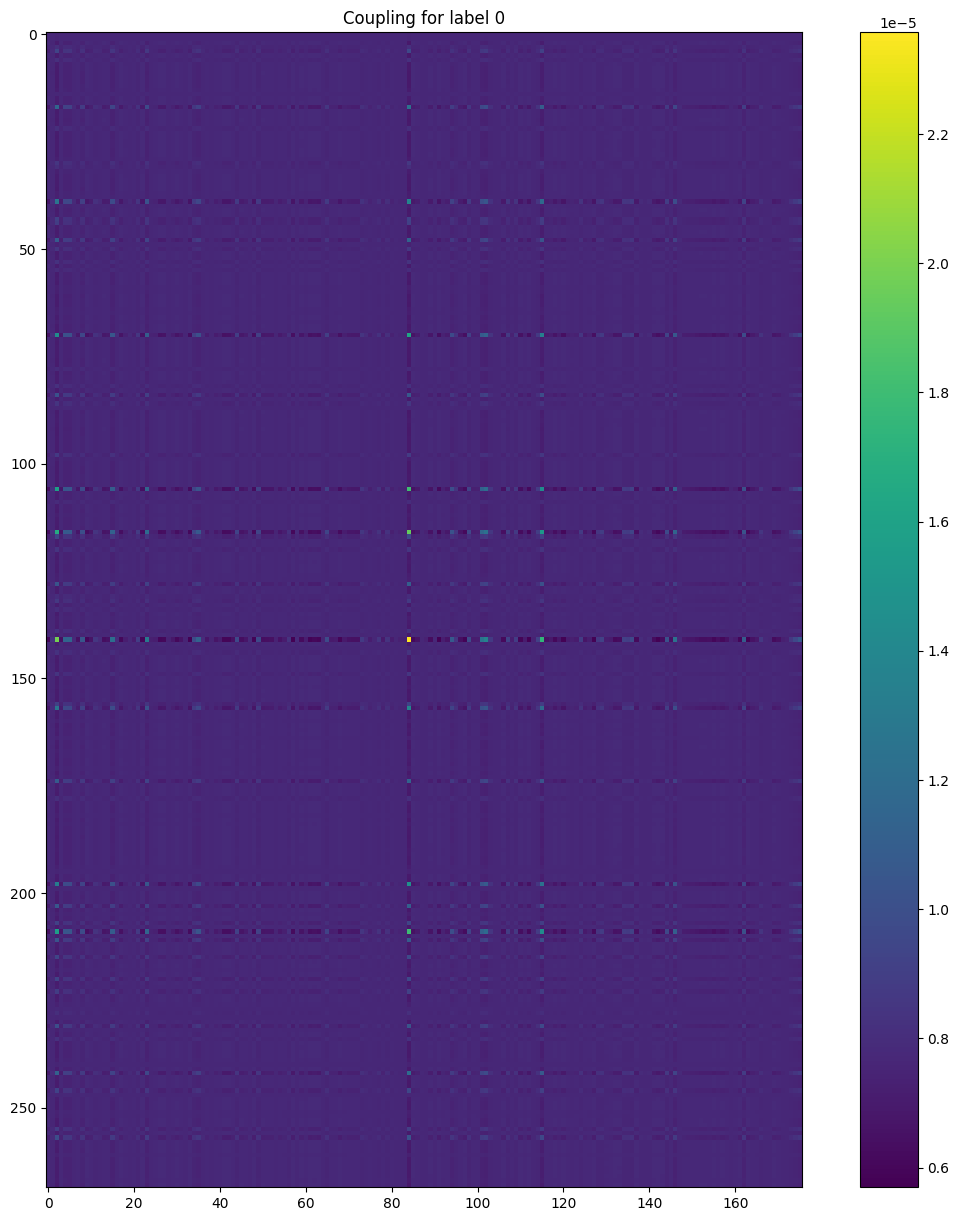

(238, 165)


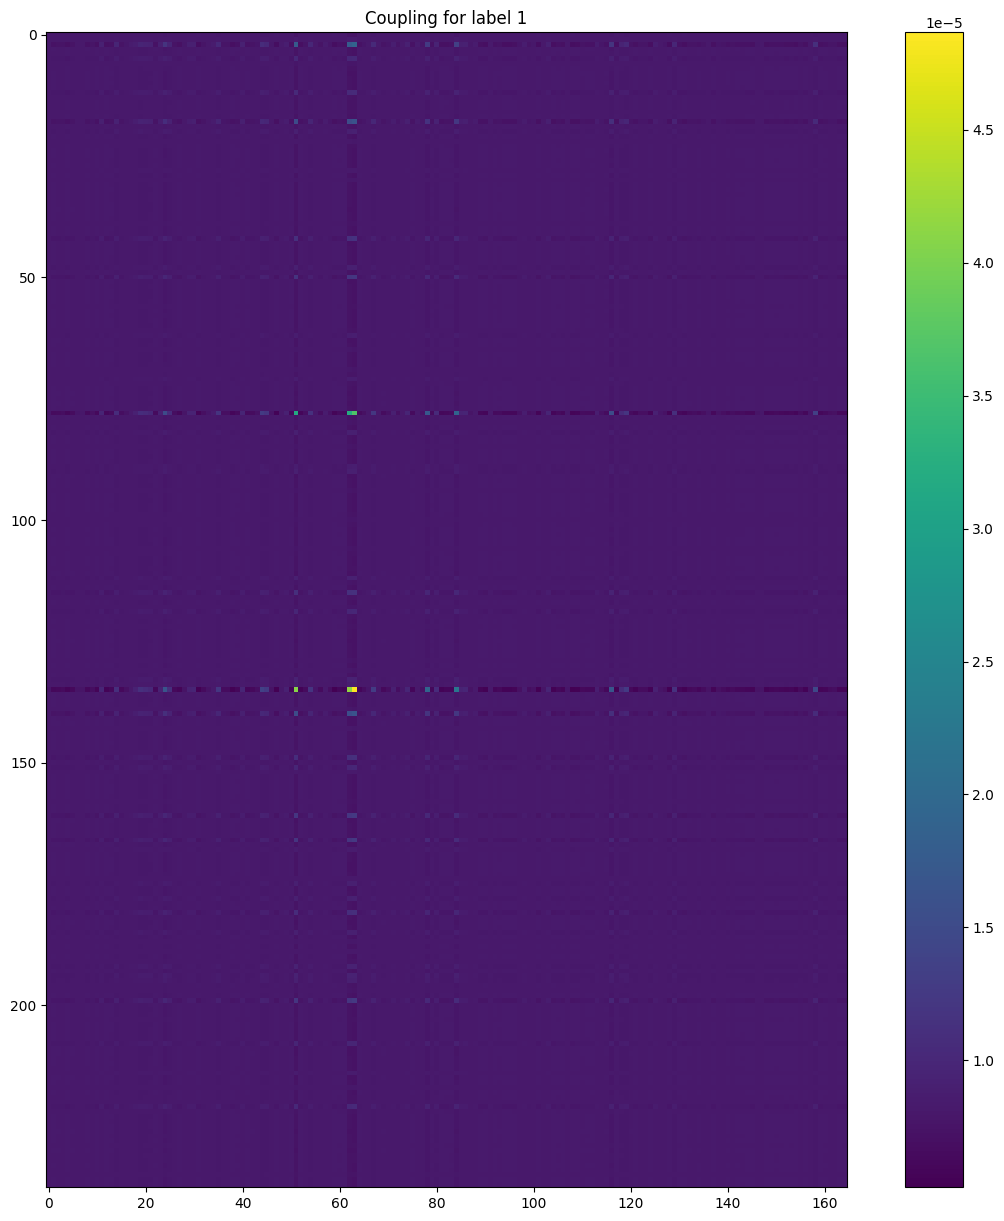

(231, 159)


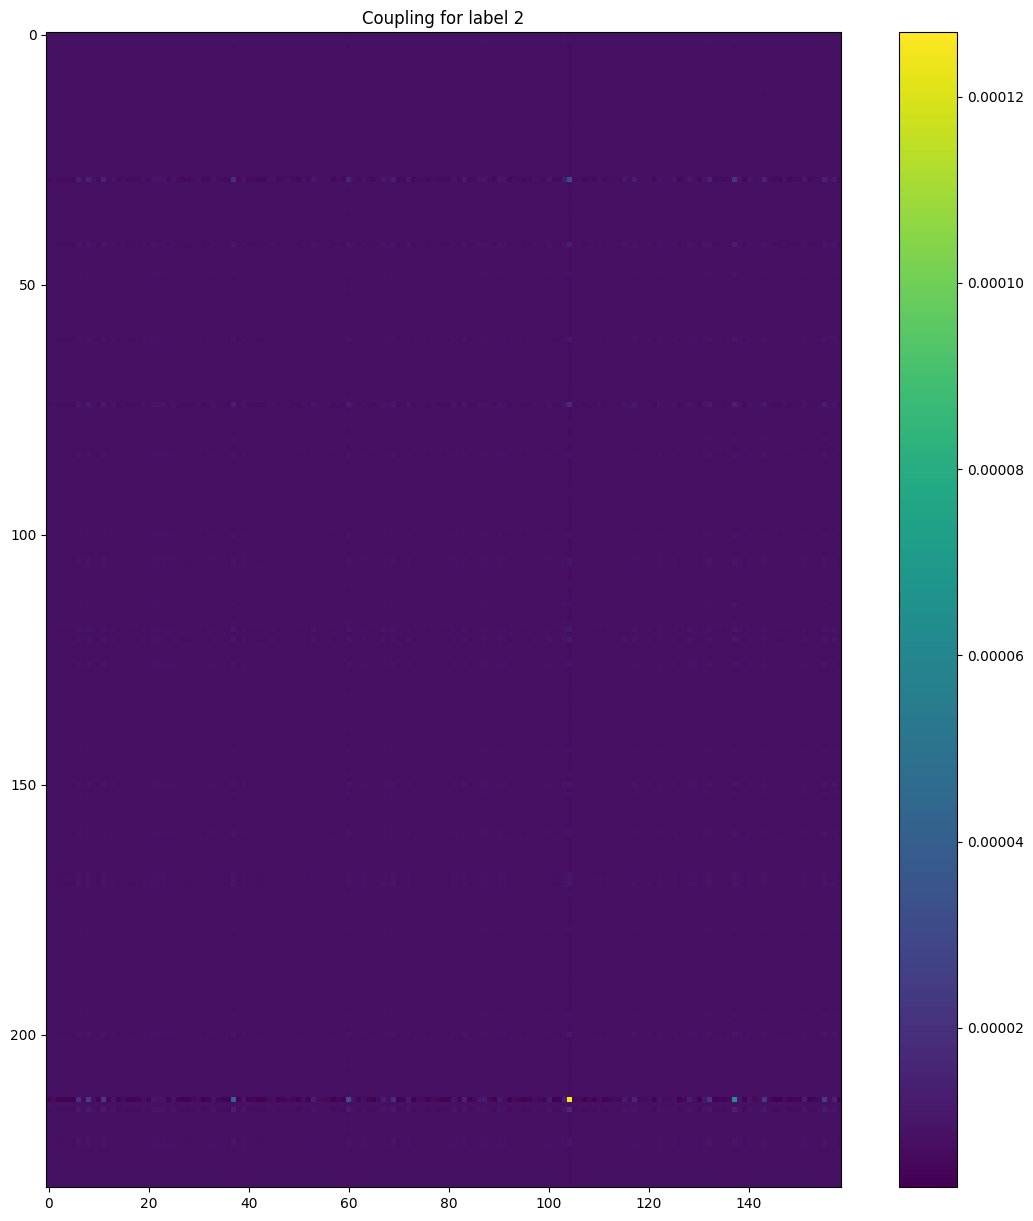

In [38]:
T_list = []
for label, T in T_dict_egw.items():
    T_list.append(T)
    print(T.shape)
    plt.figure(figsize=(15,15))
    plt.imshow(T)
    plt.colorbar()
    plt.title(f"Coupling for label {label}")
    plt.show()

In [ ]:
fullT = np.zeros((sub_rna_diet.shape[0],sub_prot_diet.shape[0]))
last_row = 0
last_col = 0
for T in T_list:
    rows, cols = T.shape
    fullT[last_row:last_row+rows,last_col:last_col+cols] = T
    last_row = last_row+rows
    last_col = last_col+cols

(738, 500)


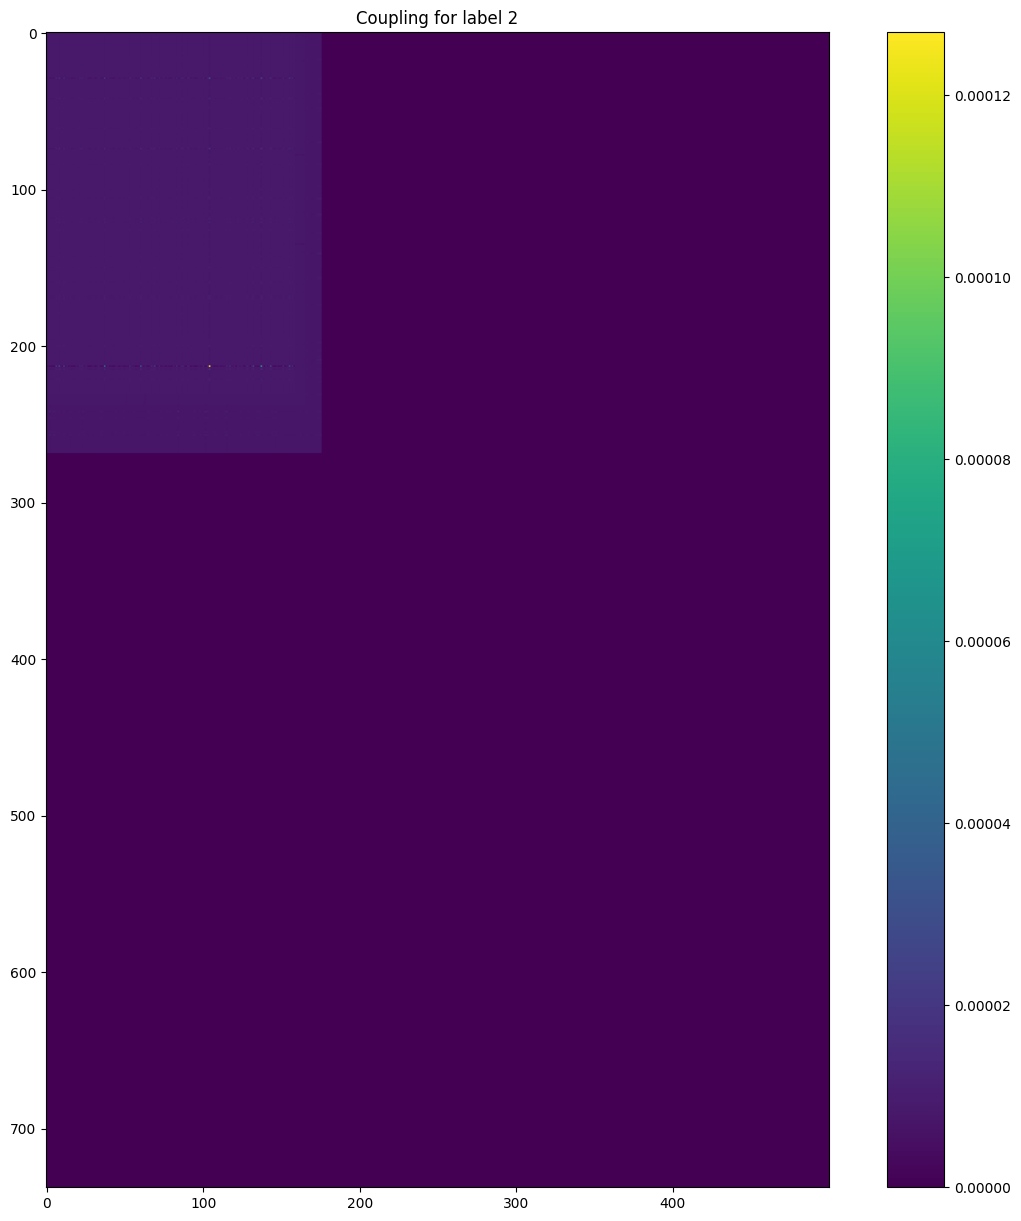

In [40]:
print(fullT.shape)
plt.figure(figsize=(15,15))
plt.imshow(fullT)
plt.colorbar()
plt.title(f"Coupling for label {label}")
plt.show()

In [ ]:
# Train MLP based on matching
model_egw, pred_log_egw = train_mlp((RNA, PROT), T_dict_egw)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 138 K 
  | other params | n/a        | 18    
--------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total 

INFO     Running sanity check on val set...                                                                        


/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the tra

Epoch 339/2000:  17%|█▋        | 339/2000 [02:59<14:38,  1.89it/s, v_num=4, train_loss_epoch=0.00922]
Monitored metric val_loss did not improve in the last 45 records. Best score: 0.010. Signaling Trainer to stop.


In [ ]:
T_dict_cotl, log_cotl = get_coupling_cotl_sinkhorn((RNA_reduced, PROT), eps=0.1)

calculating with eps 0.1
M_0:0.24742481097270863 - 40.30842145764394


lse step
M_1:0.28619675264628774 - 55.29493314960663
lse step
M_2:0.2765193322064283 - 126.09632296825934
lse step
M:3.6550152379973158 - 165.5140427858786
lse step
It 0 Delta: 1.1870878798673648e-05  Loss: 9.431186666662006
M_0:0.24742517644947432 - 40.30848617681807
lse step
M_1:0.28619596097713246 - 55.294968614103006
lse step
M_2:0.27651903513076004 - 126.09633033049302
lse step
M:3.6550152258670807 - 165.51404429116195
lse step
It 1 Delta: 1.7658711826129547e-08  Loss: 9.431188796498962
M_0:0.24742518546204345 - 40.308485493346446
lse step
M_1:0.28619596838683276 - 55.29496842431131
lse step
M_2:0.27651903712861226 - 126.09633021383812
lse step
M:3.655015236485411 - 165.5140443681635
lse step
It 2 Delta: 1.1465579596858788e-09  Loss: 9.431188792862514
converged at iter  2


In [ ]:
# Train MLP based on matching
model_cotl, pred_log_cotl = train_mlp((RNA, PROT), T_dict_cotl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type       | Params
--------------------------------------------
0 | model        | Sequential | 138 K 
  | other params | n/a        | 18    
--------------------------------------------
138 K     Trainable params
0         Non-trainable params
138 K     Total params
0.553     Total estimated model params size (MB)


INFO     Running sanity check on val set...                                                                        


/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the tra

Epoch 173/2000:   9%|▊         | 172/2000 [01:42<25:05,  1.21it/s, v_num=5, train_loss_epoch=0.00876]

/home/phalafail/MVA/Geometric_data_analysis_project/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
# for Labeled EOT, needs a 
T_dict_leot, log_leot = get_coupling_leot_ott((RNA_reduced, PROT), eps=0.1)

TypeError: dot_general requires contracting dimensions to have the same shape, got (50,) and (18,).

In [ ]:
# Train MLP based on matching
model_leot, pred_log_leot = train_mlp((RNA, PROT), T_dict_leot)